In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
%pip install statsmodels

In [1]:
import subprocess
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import theano.tensor as tt
import scipy

from packages.analysis.analyze import *

In [3]:
# use subprocess to scp a file cedar.computecanada.ca to the local machine. The file is named "all_languages_results_2023-01-28_compositional.csv". 
# The file is located in the directory "/home/fsamir8/scratch/augmentation_subset_select" on cedar.computecanada.ca. 
# Copy the file to the current directory on the local machine.
# subprocess.run(["scp", "fsamir8@cedar.computecanada.ca:/home/fsamir8/scratch/augmentation_subset_select/all_languages_results_2023-01-28_compositional.csv", "."])
# scp 4 more files that have seed=0,1,2,3 after results_ and before the date 2023-02-01
# for i in range(4):
#     subprocess.run(["scp", f"fsamir8@cedar.computecanada.ca:/home/fsamir8/scratch/augmentation_subset_select/all_languages_results_seed={i}_2023-02-01_compositional.csv", "."])


In [2]:
results_frame_first = load_results_frame_compositional("all_languages_results_2023-01-17_compositional.csv") 
# load the results frame from the file "all_languages_results_2023-01-28_compositional.csv" and store it in the variable results_frame_first
# then concatenate that with the results frame from the file "all_languages_results_2023-01-28_compositional.csv" and store it in the variable results_frame

results_frame_second = load_results_frame_compositional("all_languages_results_2023-01-28_compositional.csv")
# load the 2023-02-01 results frames and concatenate it with the above 2
for i in range(4):
    results_frame_second = pd.concat([results_frame_second, load_results_frame_compositional(f"all_languages_results_seed={i}_2023-02-01_compositional.csv")])
results_frame = pd.concat([results_frame_first, results_frame_second])
results_frame = add_kwargs_to_frame(results_frame)
results_frame = results_frame[results_frame['data_quantity'] == 'low']
# print the head of the results frame, followed by the number of rows
print(results_frame.head())
print(len(results_frame))


                                                 method  result  \
1.0   uncertainty_sample_num_aug=2048_r=1.0_train_me...   0.163   
6.0   uat_num_aug=512_train_medium=False_use_empiric...   0.237   
7.0   uncertainty_sample_num_aug=256_r=1.0_train_med...   0.212   
9.0   uncertainty_sample_num_aug=512_r=1.0_train_med...   0.238   
13.0              random_num_aug=256_train_medium=False   0.146   

     num_eval_datapoints language  num_aug  \
1.0                 1000  bengali     2048   
6.0                 1000  bengali      512   
7.0                 1000  bengali      256   
9.0                 1000  bengali      512   
13.0                1000  bengali      256   

                               method_class data_quantity  valid  
1.0         uncertainty_use_high_loss=False           low   True  
6.0   uat_use_empirical=False_use_loss=True           low   True  
7.0          uncertainty_use_high_loss=True           low   True  
9.0          uncertainty_use_high_loss=True         

In [3]:
import itertools
method_to_label_mapping = {
    "random": "Uniform",
    "uat_use_empirical=False_use_loss=True": "UMT+Loss",
    "uat_use_empirical=True_use_loss=True": "EMT+Loss",
    "uat_use_empirical=False_use_loss=False": "UMT",
    "uat_use_empirical=True_use_loss=False": "EMT",
    "uncertainty_use_high_loss=True": "HighLoss", 
    "uncertainty_use_high_loss=False": "LowLoss" 
}
# create a color mapping for each value in method_to_label_mapping.
# use the colorblind color palette from seaborn.
palette = itertools.cycle(sns.color_palette("colorblind"))
method_to_color_mapping = {v: next(palette) for v in method_to_label_mapping.values()}


# Original big plot

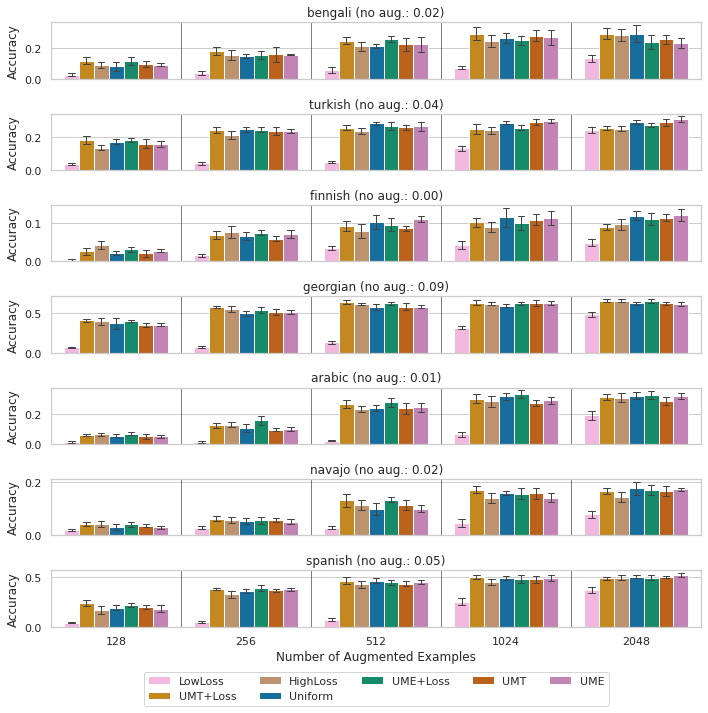

In [4]:
sns.set_theme(style="whitegrid")
# get the 'method_class' = initial performance for each language
initial_performance_series = results_frame[results_frame['method_class'] == 'initial'].groupby('language').mean()['result']
# use the above mapping to replace the method names in the results frame with the corresponding labels
big_bar_frame = results_frame.copy()
# drop rows where method_class is 'initial'
big_bar_frame = big_bar_frame[big_bar_frame['method_class'] != 'initial']
big_bar_frame['strategy'] = big_bar_frame['method_class'].map(method_to_label_mapping)

# Create a plot with as many subplots as there are languages. Each subplot will be on a different row.
# there is one column. 
# then for each language, plot the results for that language. It will be a bar plot with the x-axis being 'num_aug' and the y-axis being 'result'. The bars will be grouped by 'method_class'. 
# The title of each subplot will be the language name.
num_languages = len(big_bar_frame['language'].unique())
fig, axes = plt.subplots(num_languages, 1, figsize=(10, 10), sharex=True)
fig.subplots_adjust(hspace=0.7)  # Add some vertical space between subplots
for i, language in enumerate(big_bar_frame['language'].unique()):
    ax = axes[i]
    big_bar_frame_language = big_bar_frame[big_bar_frame['language'] == language]
    # create the bar plot with nice error bars
    graph = sns.barplot(data=big_bar_frame_language, x='num_aug', y='result', hue='strategy', 
                        ax=ax, errorbar="sd", errwidth=1, capsize=.05, palette=method_to_color_mapping
                        )

    graph.get_legend().remove()
    # get the initial performance for this language
    initial_performance = initial_performance_series[language]
    # ax.set_title(language)
    # set the title of the subplot to "{language} (no aug.: {initial_performance:.2f})"
    ax.set_title(f"{language} (no aug.: {initial_performance:.2f})")
    ax.set_ylabel('Accuracy')
    # remove the x-axis label for all subplots 
    ax.set_xlabel('')

    # get the position of the x-ticks
    xticks = ax.get_xticks()
    # get the distance between the first and second x-tick
    xtick_distance = xticks[1] - xticks[0]
    for xtick in xticks:
        ax.axvline(xtick - xtick_distance/2, color='black', linewidth=0.5)

    
    
# set the x-axis label for the last subplot
axes[-1].set_xlabel('Number of Augmented Examples')
# legend_ax = fig.add_axes([0.1, -0.15, 0.8, 0.1])
# legend = legend_ax.legend(*graph.get_legend_handles_labels(), title='Method Class', bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=5)
# legend_ax.axis('off')
axes[-1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.7), ncol=5)
plt.tight_layout()
# legend_ax = fig.add_axes([0.85, 0.15, 0.1, 0.7])
# legend = legend_ax.legend(*graph.get_legend_handles_labels(), title='Method Class', bbox_to_anchor=(1, 0.5), loc='center left')
# legend_ax.axis('off')
plt.savefig("all_results.png", dpi=300, bbox_inches='tight')

# New plot


(4, 2)


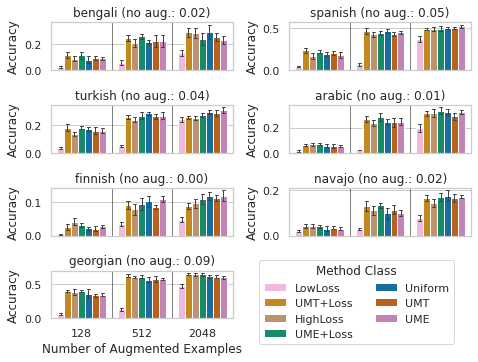

In [32]:
sns.set_theme(style="whitegrid")
# get the 'method_class' = initial performance for each language
initial_performance_series = results_frame[results_frame['method_class'] == 'initial'].groupby('language').mean()['result']
# use the above mapping to replace the method names in the results frame with the corresponding labels
big_bar_frame = results_frame.copy()
# drop rows where method_class is 'initial'
big_bar_frame = big_bar_frame[big_bar_frame['method_class'] != 'initial']
# only keep num_aug values that are in [128, 512, 2048]

big_bar_frame = big_bar_frame[big_bar_frame['num_aug'].isin([128, 512, 2048])]
big_bar_frame['strategy'] = big_bar_frame['method_class'].map(method_to_label_mapping)


num_languages = len(big_bar_frame['language'].unique())
num_rows_col1 = 4
num_rows_col2 = 3

fig, axes = plt.subplots(4, 2, figsize=(6.8, 5.2), sharex=True)
fig.subplots_adjust(hspace=0.7)  # Add some vertical space between subplots

for i, language in enumerate(big_bar_frame['language'].unique()):
    col_index = i // num_rows_col1
    row_index = i % num_rows_col1 if col_index == 0 else i % num_rows_col2

    ax = axes[row_index, col_index]  # Adjust indexing for accessing axes

    big_bar_frame_language = big_bar_frame[big_bar_frame['language'] == language]
    # create the bar plot with nice error bars
    graph = sns.barplot(data=big_bar_frame_language, x='num_aug', y='result', hue='strategy',
                        ax=ax, errorbar="sd", errwidth=1, capsize=.05, palette=method_to_color_mapping)

    graph.get_legend().remove()
    initial_performance = initial_performance_series[language]
    ax.set_title(f"{language} (no aug.: {initial_performance:.2f})")
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('')  # Remove x-axis label for all subplots

    xticks = ax.get_xticks()
    xtick_distance = xticks[1] - xticks[0]
    for xtick in xticks:
        ax.axvline(xtick - xtick_distance / 2, color='black', linewidth=0.5)

# Set the x-axis label for the last subplot in the second column
fig.delaxes(axes[-1, -1])
#fig.legend(*graph.get_legend_handles_labels(), title='Method Class', bbox_to_anchor=(0.5, -0.02), loc='upper center', ncol=5)
fig.legend(*graph.get_legend_handles_labels(), title='Strategy', loc='lower right', ncol=2, bbox_to_anchor=(0.95, 0.05))
axes[-1, 0].set_xlabel('Number of Augmented Examples')

# axes[-1, -1].set_xlabel('Number of Augmented Examples')
# axes[-1, -1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.7), ncol=5)

# axes[-1, -1].set_xlabel('Number of Augmented Examples')
# axes[-1, -1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.7), ncol=5)

# Remove empty subplots

plt.tight_layout()
plt.savefig("all_results_compressed_alt.png", dpi=300, bbox_inches='tight')
print(axes.shape)

In [5]:
# print the average accuracy for the "uat_use_empirical=False_use_loss=True" model for each language when using 128 num_aug
from packages.utils.constants import LANGUAGES

# print('Average accuracy for the "uat_use_empirical=False_use_loss=True" model for each language when using 128 num_aug')
# for language in LANGUAGES:
#     print(language, results_frame[(results_frame['method_class'] == 'uat_use_empirical=False_use_loss=True') & (results_frame['num_aug'] == 128) & (results_frame['language'] == language)]['result'].mean())
#     print(language, results_frame[(results_frame['method_class'] == 'random') & (results_frame['num_aug'] == 128) & (results_frame['language'] == language)]['result'].mean())

# print('Average accuracy for the "uat_use_empirical=False_use_loss=True" model for each language when using 256 num_aug')
# for language in LANGUAGES:
#     print(language, results_frame[(results_frame['method_class'] == 'uat_use_empirical=False_use_loss=True') & (results_frame['num_aug'] == 256) & (results_frame['language'] == language)]['result'].mean())
#     print(language, results_frame[(results_frame['method_class'] == 'random') & (results_frame['num_aug'] == 256) & (results_frame['language'] == language)]['result'].mean())

# Group the results_frame by language and num_aug, then count how many times each method_class has the highest accuracy.
# This is the same as the table in the paper.
# print('Group the results_frame by language and num_aug, then count how many times each method_class has the highest accuracy.')

# For each language and num_aug, get the method_class that has the highest accuracy from the results_frame. 

# print('For each language and num_aug, get the method_class that has the highest accuracy from the results_frame.')

def compute_win_proportions(res_frame):
    # average the accuracy over the method class for each language and num_aug
    res_frame_grouped = res_frame.groupby(['language', 'num_aug', 'strategy']).mean().reset_index()
    # print the size of the res_frame_grouped compared to the res_frame

    # get the method_class with the highest accuracy for each language and num_aug
    res_frame_grouped_max = res_frame_grouped.groupby(['language', 'num_aug']).apply(lambda x: x[x['result'] == x['result'].max()]).reset_index(drop=True)
    # drop rows with the initial method_class
    res_frame_grouped_max = res_frame_grouped_max[res_frame_grouped_max['strategy'] != 'initial']
    # print the normalized value counts of the method class from res_frame_grouped_max
    return (res_frame_grouped_max['strategy'].value_counts(normalize=True))
# win_proportions = compute_win_proportions(results_frame)
# print(win_proportions)
# print the normalized value counts of the method class from results_frame_grouped_max without the uat_use_empirical=True_use_loss=True
# print(results_frame_grouped_max[results_frame_grouped_max['method_class'] != 'uat_use_empirical=True_use_loss=True']['method_class'].value_counts(normalize=True))

# Use results_frame_grouped to get the difference in the average accuracy of method_class="uat_use_empirical=False_use_loss=True" and method_class="random" for each language and num_aug.
# Then, average the difference over the languages and num_aug.

# print('Use results_frame_grouped to get the difference in the average accuracy of method_class="uat_use_empirical=False_use_loss=True" and method_class="random" for each language and num_aug.')
# print('Then, average the difference over the languages and num_aug.')

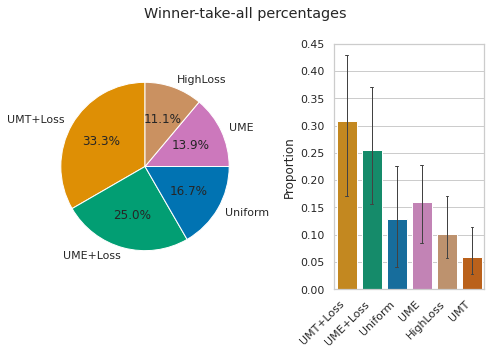

In [6]:
win_proportions = compute_win_proportions(big_bar_frame)
values = win_proportions.values
# labels = [method_to_label_mapping[label] for label in win_proportions.index]
fig, axes = plt.subplots(ncols=2, figsize=(7,5))
# # ax.pie(values, labels=labels, autopct='%1.1f%%', startangle=90)
ax = axes[0]
method_to_color_mapping
colors = [method_to_color_mapping[method] for method in win_proportions.index]
ax.pie(values, labels=win_proportions.index, autopct='%1.1f%%', startangle=90, colors=colors, radius=1.4)

bootstrap_samples = []
for i in range(100):
    bootstrap_samples.append(compute_win_proportions(big_bar_frame.sample(frac=1, replace=True)))
# then plot a bar chart of the mean and standard deviation of the bootstrap samples using seaborn
bootstrap_frame = pd.DataFrame(bootstrap_samples)
bootstrap_frame = bootstrap_frame.rename(columns=method_to_label_mapping)
bootstrap_frame = bootstrap_frame.melt()
bootstrap_frame = bootstrap_frame.rename(columns={'variable': 'Method', 'value': 'Proportion'})
ax = axes[1]
fig.suptitle("Winner-take-all percentages")
sns.barplot(x='Method', y='Proportion', data=bootstrap_frame, errorbar=('pi', 95), palette=method_to_color_mapping, errwidth=1, capsize=.1, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_xlabel(None)
plt.tight_layout()
plt.savefig("winner_take_all.png", dpi=300, bbox_inches='tight')
plt.show()

mean: 0.1811349206349206
std: 0.07996943348720845


/tmp/ipykernel_1010/2871633103.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(difference_proportions)


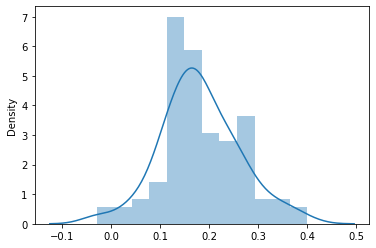

In [29]:
# get the difference between the win proportion of the uat_use_empirical=False_use_loss=True and random from the bootstrap samples
UMT_loss_proportions = [bootstrap_samples[i]['uat_use_empirical=False_use_loss=True'] for i in range(100)]
random_proportions = [(bootstrap_samples[i]['random'] if 'random' in bootstrap_samples[i] else 0) for i in range(100)]
# get the difference between UMT_loss_proportions and random_proportions
UMT_loss_proportions = np.array(UMT_loss_proportions)
random_proportions = np.array(random_proportions)
difference_proportions = UMT_loss_proportions - random_proportions
# compute the mean and standard deviation of the difference_proportions
print('mean:', np.mean(difference_proportions))
print('std:', np.std(difference_proportions))

# plot the difference_proportions using seaborn
sns.distplot(difference_proportions)
plt.show()

In [30]:
# Then, average the difference over the languages and num_aug.
# print('use the results_frame to get the difference in the average accuracy of method_class="uat_use_empirical=False_use_loss=True" and method_class="random" for each language and num_aug.')
# print('Then, average the difference over the languages and num_aug.')
results_frame_grouped = results_frame.groupby(['language', 'num_aug', 'method_class']).mean().reset_index()
# drop rows with the initial method_class
results_frame_grouped = results_frame_grouped[results_frame_grouped['method_class'] != 'initial']
# use the results_frame_grouped to get the difference in the average accuracy of method_class="uat_use_empirical=False_use_loss=True" and method_class="random" for each language and num_aug.
print(results_frame_grouped.head())

diff_frame = (results_frame_grouped).groupby(['language', 'num_aug']).apply(lambda x: x[x['method_class'] == 'uat_use_empirical=False_use_loss=True']['result'].values[0] - x[x['method_class'] == 'random']['result'].values[0])

# group by language and print the average
language_group_mean = diff_frame.groupby('language').mean()
num_aug_group_mean = diff_frame.groupby('num_aug').mean()
# create a latex table of the language_group_mean and num_aug_group_mean. 
# You can use the following code to create the table:
print(language_group_mean.to_latex())
print(num_aug_group_mean.to_latex())



# group by num_aug and print the average

# use the three statements above, but perform the groupby on results_frame_grouped without num_aug=2048 rows

# use the same two print statements as above, bt after dropping the num_aug=2048 rows
# print(diff_frame[diff_frame['num_aug'] != 2048].groupby('language').mean())
# print(diff_frame[diff_frame['num_aug'] != 2048].groupby('num_aug').mean())

  language  num_aug                            method_class    result  valid
1   arabic      128                                  random  0.056167    1.0
2   arabic      128  uat_use_empirical=False_use_loss=False  0.052500    1.0
3   arabic      128   uat_use_empirical=False_use_loss=True  0.061333    1.0
4   arabic      128   uat_use_empirical=True_use_loss=False  0.053000    1.0
5   arabic      128    uat_use_empirical=True_use_loss=True  0.070167    1.0
\begin{tabular}{lr}
\toprule
{} &         0 \\
language &           \\
\midrule
arabic   &  0.004767 \\
bengali  &  0.025733 \\
finnish  & -0.009000 \\
georgian &  0.048433 \\
navajo   &  0.011333 \\
spanish  &  0.013100 \\
turkish  & -0.019033 \\
\bottomrule
\end{tabular}

\begin{tabular}{lr}
\toprule
{} &         0 \\
num\_aug &           \\
\midrule
128     &  0.021619 \\
256     &  0.022976 \\
512     &  0.016024 \\
1024    &  0.003262 \\
2048    & -0.010071 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_1010/714876310.py:17: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(language_group_mean.to_latex())
/tmp/ipykernel_1010/714876310.py:18: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(num_aug_group_mean.to_latex())


<AxesSubplot:xlabel='num_aug', ylabel='mean_loss_diff'>

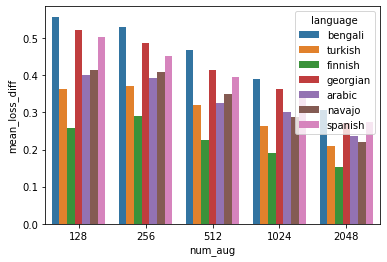

In [33]:
# random,uat_use_empirical=False_use_loss=True
nll_frame = pd.read_csv('nlls.csv')
# for every row, calculate the difference between 'random' and 'uat_use_empirical=False_use_loss=True'. Save it as a column mean_loss_diff in the dataframe.
nll_frame['mean_loss_diff'] =  nll_frame['uat_use_empirical=False_use_loss=True'] - nll_frame['random']
# plot the mean_loss_diff using seaborn. The x-axis should be num_aug and the y-axis should be mean_loss_diff. The hue should be language.
sns.barplot(x='num_aug', y='mean_loss_diff', hue='language', data=nll_frame)



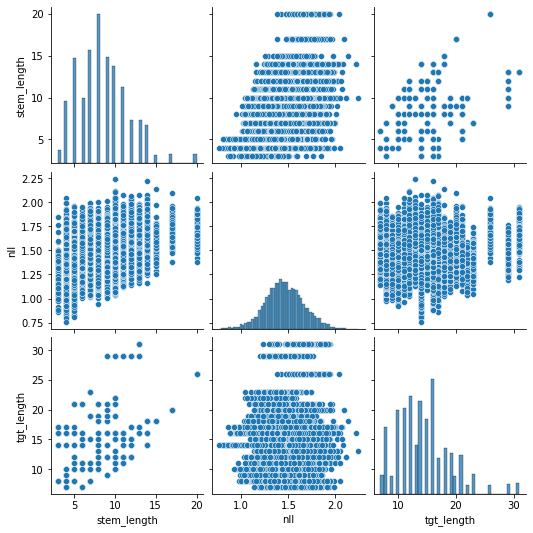

In [24]:
# load the csv in "analysis/2023-03-08/loss_analysis_frame_finnish_100000.csv" into a dataframe. Only take the nll, levenstein_distance, and invariant columns.
loss_analysis_frame = pd.read_csv('analysis/2023-03-08/loss_analysis_frame_finnish_100000.csv')
loss_analysis_frame = loss_analysis_frame[['nll', 'levenstein_distance', 'invariant', 'tgt']]
# add a column 'stem_length' which is the length of the invariant column. note that x is a string which should be treated as a list.
loss_analysis_frame['stem_length'] = loss_analysis_frame['invariant'].apply(lambda x: len(x[1:-1].split(',')))
# # add a column 'tgt_length' which is the length of the tgt column.
loss_analysis_frame['tgt_length'] = loss_analysis_frame['tgt'].apply(lambda x: len(x))
# take a random sample of 10000 rows from the loss_analysis_frame
loss_analysis_frame = loss_analysis_frame.sample(10000)
# plot the pairwise relationships between stem_length, nll, and levenstein_distance using seaborn.
sns.pairplot(loss_analysis_frame, vars=['stem_length', 'nll', 'tgt_length'])
plt.show()

In [32]:
# for each CSVs in .analysis/2023-03-08, load it into a dataframe. Then, print the correlation between the nll and stem_length, and nll and tgt_length.
# You can use the following code to print the correlation:
import os

# create a dataframe with the following columns: language, nll_correlation, correlation_type.
correlation_frame = pd.DataFrame(columns=['language', 'correlation', 'correlation_type']) 
for fname in os.listdir('analysis/2023-03-08'):
    print(fname)
    frame = pd.read_csv(os.path.join('analysis/2023-03-08', fname))
    frame['stem_length'] = frame['invariant'].apply(lambda x: len(x[1:-1].split(',')))
# # add a column 'tgt_length' which is the length of the tgt column.
    frame['tgt_length'] = frame['tgt'].apply(lambda x: len(x))
    stem_length_corr = frame['stem_length'].corr(frame['nll'])
    tgt_length_corr = frame['tgt_length'].corr(frame['nll'])
    levenstein_distance_corr = frame['levenstein_distance'].corr(frame['nll'])


    print(f"Correlation between NLL and stem length: {frame['stem_length'].corr(frame['nll'])}")
    print(f"Correlation between NLL and tgt length: {frame['tgt_length'].corr(frame['nll'])}")
    # also print the correlation between nll and levenstein_distance
    print(f"Correlation between NLL and levenstein distance: {frame['levenstein_distance'].corr(frame['nll'])}")
    language = fname.split('_')[3]
    # frame = frame.append({'language': language, 'correlation': stem_length_corr, 'correlation_type': 'stem_length'}, ignore_index=True)
    # use concat to add the rows to the dataframe
    correlation_frame = pd.concat([correlation_frame, pd.DataFrame({'language': [language], 'correlation': [stem_length_corr], 'correlation_type': ['stem_length']})])
    correlation_frame = pd.concat([correlation_frame, pd.DataFrame({'language': [language], 'correlation': [tgt_length_corr], 'correlation_type': ['tgt_length']})])
    correlation_frame = pd.concat([correlation_frame, pd.DataFrame({'language': [language], 'correlation': [levenstein_distance_corr], 'correlation_type': ['levenstein_distance']})])

# i create a barplot. The x-axis will be the language, the y-axis will be the correlation between nll and some other column
print(correlation_frame)
correlation_frame['correlation_type'] = correlation_frame['correlation_type'].map({"stem_length": "stem length", "tgt_length": "target length", "levenstein_distance": "lev. distance"})


loss_analysis_frame_bengali_100000.csv
Correlation between NLL and stem length: 0.14273602135121471
Correlation between NLL and tgt length: -0.057039862888980025
Correlation between NLL and levenstein distance: 0.44850279673257926
loss_analysis_frame_arabic_100000.csv
Correlation between NLL and stem length: 0.24712708210905432
Correlation between NLL and tgt length: -0.043244888903744644
Correlation between NLL and levenstein distance: 0.5442131844559412
loss_analysis_frame_navajo_100000.csv
Correlation between NLL and stem length: 0.20721746839558378
Correlation between NLL and tgt length: 0.006320863810822566
Correlation between NLL and levenstein distance: 0.45652467718221706
loss_analysis_frame_finnish_100000.csv
Correlation between NLL and stem length: 0.450078767419706
Correlation between NLL and tgt length: 0.10856645585846406
Correlation between NLL and levenstein distance: 0.37999408245197813
loss_analysis_frame_spanish_100000.csv
Correlation between NLL and stem length: 0.16

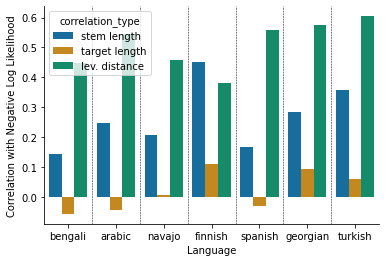

In [36]:
# plot the correlation_frame using seaborn. The x-axis should be language, the y-axis should be correlation, and the hue should be correlation_type.
# change the "correlation_type" column to map to {"stem_length": "stem length", "tgt_length": "target length", "levenstein_distance": "lev. distance"}
graph = sns.barplot(x='language', y='correlation', hue='correlation_type', data=correlation_frame, palette='colorblind')

ax = graph.axes
xticks = ax.get_xticks()
# get the distance between the first and second x-tick
xtick_distance = xticks[1] - xticks[0]
for xtick in xticks:
    # draw a vertical line at the midpoint of each xtick.
    ax.axvline(xtick + xtick_distance / 2, color='black', linestyle='--', linewidth=0.5)
# remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# set the y-label to "frequency of most frequent tag
# set the x-label to "Language"
# set the title to "Frequency of Most Frequent Tag
ax.set_ylabel("Correlation with Negative Log Likelihood")
ax.set_xlabel("Language")




# save a high resolution version of the graph using the following code:
graph.figure.savefig("correlation_nll.png", dpi=300)

# create a latex table of the correlation_frame. You can use the following code to create the table:
# print(correlation_frame.to_latex(index=False))


In [18]:
# fit a regression model using nll as the dependent variable and stem length and levenstein_distance as the independent variables.
# You can use the following code to fit the model:
import statsmodels.api as sm
X = loss_analysis_frame[['stem_length', 'tgt_length']]
y = loss_analysis_frame['nll']
# add a constant to X
print(X)
# model = sm.OLS(y, X).fit()
# print(model.summary())


       stem_length  tgt_length
53224           46          16
50136           28          21
96384           34          12
50343           28          21
80092           42          16
...            ...         ...
52022           30          12
95614           46          14
65336           21          15
75503           24          11
3245            46          14

[10000 rows x 2 columns]


In [ ]:
macro_acc_frame = pd.read_csv('all_languages_results_2023-03-09_seed=2_aug_pool_size=100000_compositional.csv')

macro_acc_frame = add_kwargs_to_frame(macro_acc_frame)
print(macro_acc_frame.head())
# sns.barplot(x='num_aug', y='result', hue='method_class', data=macro_acc_frame)

# plot the result using x='num_aug', y='result', hue='method_class'. Use a different ax for each language.
# You can use the following code to create the figure:
fig, axes = plt.subplots(len(macro_acc_frame['language'].unique()), 1, figsize=(10, 10))
for i, language in enumerate(macro_acc_frame['language'].unique()):
    sns.barplot(x='num_aug', y='macro_avg_acc', hue='method_class', data=macro_acc_frame[macro_acc_frame['language'] == language], ax=axes[i])
    axes[i].set_title(language)
    axes[i].set_xlabel('Number of Augmentations')
    axes[i].set_ylabel('Accuracy')
    axes[i].set_ylim(0, 1)


In [12]:
tag_count_frame = pd.read_csv("tag_counts.csv")
# plot the distribution of tag counts using seaborn. Do it for language='bengali'. Set the hue to be 'strategy'
# sns.displot(tag_count_frame[tag_count_frame['language'] == 'bengali'], x='count', hue='strategy', kind='hist')

# print the number of unique tags for language='bengali' for each strategy
# print(tag_count_frame[tag_count_frame['language'] == 'bengali'].groupby('strategy')['tag'].nunique())
# # print the highest tag count for language='bengali' for each strategy
# print(tag_count_frame[tag_count_frame['language'] == 'bengali'].groupby('strategy')['count'].max())

# print the highest tag count for each strategy. Loop over the unique languages in the tag_count_frame.
method_to_label_mapping_2 = {
    "random": "random",
    "uat": "UMT+Loss",
    "uncertainty_sample": "HighLoss", 
}
# create a color mapping for each value in method_to_label_mapping.
# use the colorblind color palette from seaborn.
# palette = itertools.cycle(sns.color_palette("colorblind"))
# method_to_color_mapping = {v: next(palette) for v in method_to_label_mapping.values()}
tag_count_frame['strategy'] = tag_count_frame['strategy'].map(method_to_label_mapping_2)
# graph = sns.barplot(data=big_bar_frame_language, x='num_aug', y='result', hue='strategy', 
#                     ax=ax, errorbar="sd", errwidth=1, capsize=.05, palette=method_to_color_mapping
#                     )

# rename values in the tag_count_frame['strategy'] column using the method_to_label_mapping

# for language in tag_count_frame['language'].unique():
#     print(f"Language: {language}")
#     print(tag_count_frame[tag_count_frame['language'] == language].groupby('strategy')['count'].max())
#     language_tag_count_frame = tag_count_frame[tag_count_frame['language'] == language]

# graph = sns.barplot(data=tag_count_frame, x='strategy', y='count', hue='language', palette=method_to_color_mapping)
    # plot these counts by setting the language as the x-axis. Then the hue is the strategy. Then the y-axis is the max count.

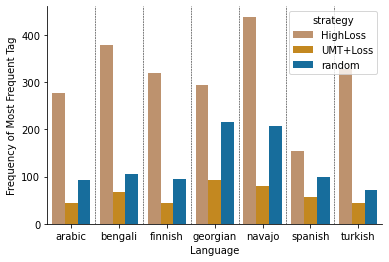

In [18]:
max_count_frame = tag_count_frame.groupby(['language', 'strategy'])['count'].max()
# collapse the max_count_frame into a dataframe with language and strategy as the columns and count as the values.
# use the following code to create the dataframe:
max_count_frame = max_count_frame.reset_index()
# plot using seaborn the max_count_frame. The x-axis should be language, the y-axis should be count, and the hue should be strategy. Use the method_to_color_mapping to set the colors.
graph = sns.barplot(data=max_count_frame, x='language', y='count', hue='strategy', palette=method_to_color_mapping)
# get the axis of the graph
ax = graph.axes
xticks = ax.get_xticks()
# get the distance between the first and second x-tick
xtick_distance = xticks[1] - xticks[0]
for xtick in xticks:
    # draw a vertical line at the midpoint of each xtick.
    ax.axvline(xtick + xtick_distance / 2, color='black', linestyle='--', linewidth=0.5)
# remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# set the y-label to "frequency of most frequent tag
# set the x-label to "Language"
# set the title to "Frequency of Most Frequent Tag
ax.set_ylabel("Frequency of Most Frequent Tag")
ax.set_xlabel("Language")




# save a high resolution version of the graph using the following code:
graph.figure.savefig("max_tag_count.png", dpi=300)


In [2]:
from os.path import commonprefix
import panphon 

ft = p
def get_stem_indices(src_ipa, tgt_ipa):
    # compute the longest common substring between src_ipa and tgt_ipa.
    # return the start and end indices of the longest common substring in src_ipa and tgt_ipa.
    common_prefix = commonprefix([src_ipa, tgt_ipa])
    return (0, len(common_prefix)) # watch out for off-by-one errors

def get_last_vowel_index(ipa_form):


In [ ]:
import panphon
import epitran
epi = epitran.Epitran('tur-Latn')
ft = panphon.FeatureTable()

def inspect_vowel_harmony(inflection_frame: pd.DataFrame):
    """Counts the number of vowel harmony violations for each example in the 
    inflection_frame.

    Args:
        inflection_frame (pd.DataFrame): dataframe containing two columns: src and tgt.
    """
    # get the ipa representation of the source and target
    inflection_frame['src_ipa'] = inflection_frame['src'].apply(epi.transliterate)
    inflection_frame['tgt_ipa'] = inflection_frame['tgt'].apply(epi.transliterate)
    # get the start and end of stem indices using longest common substring.
    inflection_frame[['stem_start', 'stem_end']] = inflection_frame.apply(lambda x: get_stem_indices(x['src_ipa'], x['tgt_ipa']), axis=1)
    # get the index of the last vowel in the stem.
    inflection_frame['last_vowel_index'] = inflection_frame.apply(lambda x: get_last_vowel_index(x['src_ipa'], x['stem_start'], x['stem_end']), axis=1)
    # get the highness feature of the last vowel in the stem using panphon feature table.
    inflection_frame['last_vowel_highness'] = inflection_frame.apply(lambda x: get_last_vowel_highness(x['src_ipa'], x['last_vowel_index']), axis=1)
    # check that the vowels in the suffixes have the same highness feature as the last vowel in the stem.
    inflection_frame['is_harmonious'] = inflection_frame.apply(lambda x: get_vowel_harmony_violations(x['tgt_ipa'], x['stem_end'], x['last_vowel_highness']), axis=1)
    # count the number of vowel harmony violations; this is the number of False values in the is_harmonious column.
    # return the number of vowel harmony violations.
    num_violations = len(inflection_frame[inflection_frame['is_harmonious'] == False])
    return num_violations 

    # turkish_example_frame['aug_tgt_ipa'] = turkish_example_frame['tgt'].apply(epi.transliterate)

    # get the start and end of stem indices using longest common substring. 
    # then get the index of the last vowel in the stem. 

    # then, count the number of vowel harmony violations for the examples.




    
